# Generalization Behaviour

In [1]:
import warnings
warnings.filterwarnings('ignore')
import inspect
import os
import logging
import numpy as np
import pandas as pd
from docopt import docopt
from csrank import FATEObjectRanker, FETAObjectRanker, ObjectRankingDatasetGenerator
from csrank.callbacks import DebugOutput
from csrank.metrics import zero_one_rank_loss_for_scores
from csrank.util import rename_file_if_exist, configure_logging_numpy_keras, get_tensor_value
from keras.callbacks import History

Using TensorFlow backend.


Defining the Constants

In [2]:
MODEL = "aModel"
ERROR_OUTPUT_STRING = 'Out of sample error {} : {} for n_objects {}'
his = History()
his.__name__ = "History"
objects = "Objects"

## The Medoid Problem
In the medoid problem the goal of the learner is to sort a set of randomly generated points based on their distance to the _medoid_.
This problem is inspired by the setting of ranking similarity learning, where the goal is to learn a similarity function from triplets of objects.

We will generate a random dataset where each instance contains provided number objects and 2 features. 

In [3]:
def generate_dataset(n_objects=5, random_state=42):
    parameters = {"n_features": 2, "n_objects": n_objects, 
                  "n_train_instances": 10000, "n_test_instances": 100000,
                  "dataset_type": "medoid",
                  "random_state":random_state}
    generator = ObjectRankingDatasetGenerator(**parameters)
    return generator.get_single_train_test_split()

## Evaluation on different size rankings
Fit the given ranker and predict on rankings with different sizes and check the zero one rank loss for them to see the generalizing behaviour of the rankers.

In [9]:
def get_evaluation_result(gor, X_train, Y_train, epochs):
    gor.fit(X_train, Y_train, callbacks=[DebugOutput(delta=10), his], verbose=False, epochs=epochs)
    eval_results = {}
    for n_objects in np.arange(3, 20):
        _, _, X_test, Y_test = generate_dataset(n_objects=n_objects, random_state=seed + n_objects * 5)
        y_pred_scores = gor.predict_scores(X_test, batch_size=X_test.shape[0])
        metric_loss = get_tensor_value(zero_one_rank_loss_for_scores(Y_test, y_pred_scores))
        logger.info(ERROR_OUTPUT_STRING.format("zero_one_rank_loss", str(np.mean(metric_loss)), n_objects))
        eval_results[n_objects] = metric_loss
    return eval_results

Initialize the log file path and the dataframe path.

In [10]:
n_objects = 5
dirname = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
log_path = os.path.join(dirname, "logs", "generalizing_mean_{}.log".format(n_objects))
df_path = os.path.join(dirname, "logs", "generalizing_mean_{}.csv".format(n_objects))
random_state = np.random.RandomState(seed=42)
seed = random_state.randint(2 ** 32)

Initialize tensorflow and keras with the seed and initialize the log file path

In [13]:
rows_list = []
configure_logging_numpy_keras(seed=seed, log_path=log_path)
logger = logging.getLogger("Experiment")
X_train, Y_train, _, _ = generate_dataset(n_objects=n_objects, random_state=seed)
n_instances, n_objects, n_features = X_train.shape

epochs = 500
params = {"n_objects": n_objects, 
          "n_features": n_features, 
          "n_object_features": n_features, 
          "use_early_stopping": True, 
          "metrics":[zero_one_rank_loss_for_scores]}

Evaluate the FETANetwork with best parameters and check the generalization

In [ ]:
logger.info("############################# With Best Parameters FETA ##############################")
gor = FETAObjectRanker(**params)
result = get_evaluation_result(gor, X_train, Y_train, epochs)
result[MODEL] = "FETARankerDefault"
rows_list.append(result)

Evaluate the FATEObjectRanker with best parameters and check the generalization

In [ ]:
from csrank.losses import smooth_rank_loss
logger.info("############################# With Best Parameters FATE ##############################")
gor = FATEObjectRanker(**params)
result = get_evaluation_result(gor, X_train, Y_train, epochs)
result[MODEL] = "FATERankerDefault"
rows_list.append(result)

Save the results into a dataframe

In [70]:
df = pd.DataFrame(rows_list)
df = df.set_index(MODEL).T
cols = list(df.columns.values)
df

aModel,FATERankerDefault
3,0.218561
4,0.947871
5,0.692061
6,0.669744
7,0.932732
8,0.804914
9,0.941135
10,0.964858
11,0.970023
12,0.090049


If the there is an existing csv file saved then load it and add the new columns containing the results to it

In [8]:
if not os.path.isfile(df_path):
    dataFrame = df
else:
    dataFrame = pd.read_csv(df_path, index_col=0)
    dataFrame = dataFrame.append(df, ignore_index=True)
dataFrame

,Objects,FETARanker,FATERanker
0,3,0.194951,0.065285
1,4,0.228402,0.120779
2,5,0.224131,0.103804
3,6,0.227914,0.109337
4,7,0.228970,0.110699
5,8,0.230498,0.112166
6,9,0.230520,0.113533
7,10,0.230697,0.115446
8,11,0.230296,0.116400
9,12,0.230299,0.116445


Save the dataframe to given file path

In [9]:
dataFrame.to_csv(df_path, index=objects)

Plot the results of the zero one rank accuracy.
It takes too much time to run this experiment. 
The stored results are used to plot the generalization behaviour of the rankers.

<IPython.core.display.Javascript object>


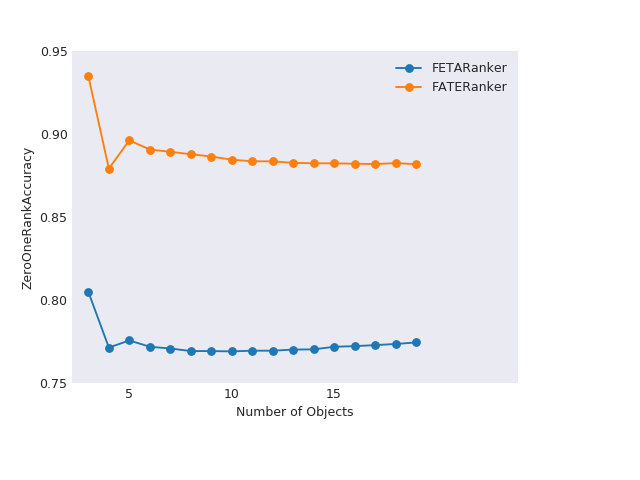

In [10]:
import matplotlib.pyplot as plt
%matplotlib notebook

import seaborn as sns; 
sns.set(color_codes=True)
plt.style.use('default')
sns.set_style("dark")

y_label="ZeroOneRankAccuracy"
x_label="Number of Objects"
fig, ax = plt.subplots()
for col in dataFrame.columns.values[1:]:
    plt.plot(dataFrame[dataFrame.columns.values[0]], 1 - dataFrame[col], marker="o",label=col)
ax.xaxis.set_ticks(np.arange(3, 25))
ax.set_ylabel(y_label)
ax.set_xlabel(x_label)
plt.xticks(np.arange(5, 20, 5))
plt.yticks(np.arange(0.75,1.0,0.05))
plt.legend(loc="best")
plt.show()

Save the plot

In [11]:
plot_path =os.path.join(os.getcwd(), "logs" ,"generalizing.png")
plt.savefig(plot_path, facecolor='w', edgecolor='w',transparent=False, dpi=800,format='png')